In [103]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.backends.backend_pdf

sns.set_theme(color_codes=True)

import blitzgsea as blitz


# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


In [78]:
random.seed(18)
seed = random.random()
print(random.random())

0.6614305484952444


In [79]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - MoTrPAC_2023
16 - Kinase_Perturbations_from_GEO_down
17 - Disease_Signatures_from_GEO_down_2014
18 - Disease_Perturbations_from_GEO_up
19 - Old_CMAP_down
20 - MCF7_Perturbations_from_GEO_up
21 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
22 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
23 - PPI_Hub_Proteins
24 - Disease_Signatures_from_GEO_up_2014
25 - GTEx_Tissue_Expression_Up
26 - L1000_Kinase_a

In [80]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("Reactome_2022")

In [81]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE/results/weight_matrix_gsea.parquet").resolve()
signature = pd.read_parquet(gene_weight_dir)
print(signature.shape)
signature.head()

(2718, 73)


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,AAAS,-0.029648,0.070605,-0.142056,-0.136777,-0.222449,0.025861,-0.036514,0.015436,0.049837,...,0.074131,0.003742,0.013311,-0.034091,0.036546,0.042408,-0.015514,0.078286,-0.008753,-0.023630
1,AAMP,0.139939,0.053766,-0.038851,-0.055015,0.103119,-0.003519,0.067513,0.038110,-0.159354,...,0.091614,0.026098,0.007294,0.054157,-0.018419,0.085175,-0.025353,0.031713,0.105514,-0.009389
2,AARS1,-0.029446,-0.005102,0.023082,0.059505,0.032885,-0.050433,-0.160086,-0.076602,0.286948,...,-0.053943,-0.008631,-0.021420,-0.003622,0.015946,0.117308,0.120526,0.122062,-0.048667,0.083917
3,AARS2,0.347551,0.120056,-0.306340,-0.196994,0.047495,0.293353,0.267543,0.427548,-0.107472,...,0.038747,-0.082284,0.025216,0.054058,-0.022778,0.163873,-0.009841,-0.025877,0.028444,-0.027354
4,AASDHPPT,0.264927,0.243652,-0.088062,0.043917,-0.105922,0.283789,0.164702,0.165618,0.019526,...,-0.139645,0.004266,-0.100743,-0.103351,0.045809,-0.000606,-0.033179,-0.072038,0.037288,-0.029683


In [82]:
# Running GSEA

all_GSEA_results = []
all_signatures = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range].columns:
    df = signature.iloc[:,[0,int(col)]]
    result = blitz.gsea(df, library, seed=seed)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)

In [84]:
# Copying signature dataframe without gene column
neg_signature = signature.iloc[:, 1:].copy()

# Vertically shuffling the data in each column to create a negative control
for col in neg_signature.columns:
    neg_signature.loc[:, col] = np.random.permutation(neg_signature.loc[:, col].values)

# Adding gene column back to finalize negative control data
genes = signature.iloc[:,:1]
neg_signature.insert(0,'0', genes)

# Running GSEA with negative control data
neg_GSEA_results = []
negative_control = []

range = neg_signature.shape[1]

for col in neg_signature.iloc[:,1:range].columns:
    neg_df = neg_signature.iloc[:,[0,int(col)]]
    neg_result = blitz.gsea(neg_df, library, seed=seed)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [85]:
# stack up all of the results to be analyzed
all_GSEA_results= pd.concat(all_GSEA_results)
neg_GSEA_results = pd.concat(neg_GSEA_results)

# merging real and negative control gsea results to single dataframe with column specifying source
all_GSEA_results['source'] = 'real'
neg_GSEA_results['source'] = 'negative control'

combo_gsea_df = pd.concat([all_GSEA_results, neg_GSEA_results])

# Define cut-offs
lfc_cutoff = 0.584
fdr_cutoff = 0.25

# Filter data for significant results
significant_gsea_df = all_GSEA_results[
    (all_GSEA_results['es'].abs() > lfc_cutoff) & 
    (all_GSEA_results['fdr'] < fdr_cutoff)
]
significant_negs = neg_GSEA_results[
    (neg_GSEA_results['es'].abs() > lfc_cutoff) & 
    (neg_GSEA_results['fdr'] < fdr_cutoff)
]

In [86]:
# saving significant gsea results as single output file
significant_gsea_dir = pathlib.Path("./results/significant_gsea_results.parquet.gz")
significant_gsea_df.to_parquet(significant_gsea_dir, compression = 'gzip')

# saving gsea results as single output file
combo_gsea_dir = pathlib.Path("./results/combined_gsea_results.parquet.gz")
combo_gsea_df.to_parquet(combo_gsea_dir, compression = 'gzip')

In [87]:
# sort by what you want to evaluate
combo_gsea_df.sort_values(by='nes', ascending = True)
significant_gsea_df.sort_values(by='nes', ascending = True)

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim,source
Term,,,,,,,,,
Mitotic Metaphase And Anaphase R-HSA-2555396,-0.602681,-7.611815,2.702732e-14,2.805436e-11,1.371589e-11,147,"SGO1,CKAP5,PSMC2,PSMA2,NUP98,SEM1,CDC23,PSMD2,...",z_14,real
Mitotic Anaphase R-HSA-68882,-0.600761,-7.562166,3.964129e-14,4.114766e-11,1.371589e-11,146,"SPC24,PSMA4,ANAPC5,SGO1,CDC27,CKAP5,SMC3,NUP13...",z_14,real
Processing Of Capped Intron-Containing Pre-mRNA R-HSA-72203,-0.625820,-7.473913,7.784466e-14,8.080276e-11,8.080276e-11,141,"POLR2D,NUP155,SNRPF,SRRT,U2AF2,SRSF3,SF3B5,LSM...",z_12,real
Processing Of Capped Intron-Containing Pre-mRNA R-HSA-72203,-0.599261,-7.441026,9.990637e-14,1.037028e-10,2.592570e-11,141,"SNU13,GTF2F2,PRPF6,LSM2,SF3B1,SNRNP70,HNRNPK,R...",z_14,real
HIV Infection R-HSA-162906,-0.598563,-7.375898,1.632405e-13,1.694437e-10,3.388873e-11,138,"PSMA4,POLR2G,VPS28,GTF2B,SSRP1,GTF2F2,PSMC2,TS...",z_14,real
...,...,...,...,...,...,...,...,...,...
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,0.808322,8.125891,5.285157e-16,5.485993e-13,5.485993e-13,86,"UQCRFS1,NDUFA2,NDUFV2,OGDH,ATP5PB,ATP5F1A,NDUF...",z_7,real
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,0.832348,8.209536,2.805762e-16,2.912381e-13,2.912381e-13,86,"NDUFS1,NUBPL,NDUFAF3,NDUFA6,NDUFB9,ATP5PF,NDUF...",z_40,real
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,0.831122,8.209536,2.134325e-16,2.215430e-13,2.215430e-13,86,"ATP5F1B,NDUFAF5,NDUFV2,NDUFA6,CYCS,NDUFB2,NDUF...",z_28,real


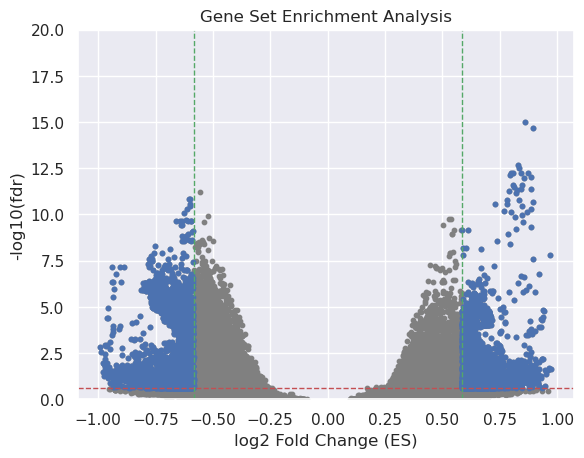

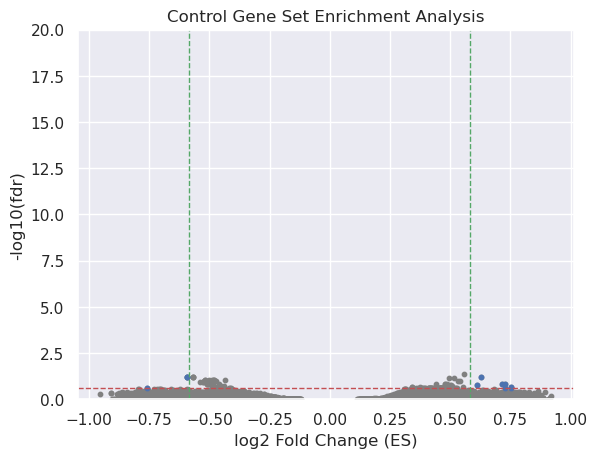

In [105]:
# Define cut-offs
lfc_cutoff = 0.584
fdr_cutoff = 0.25
significant_results = all_GSEA_results[
    (all_GSEA_results['es'].abs() > lfc_cutoff) & 
    (all_GSEA_results['fdr'] < fdr_cutoff)
]
plt.figure()
plt.scatter(x=all_GSEA_results['es'],y=all_GSEA_results['fdr'].apply(lambda x:-np.log10(x)),s=10, color='grey')
plt.scatter(x=significant_results['es'],y=significant_results['fdr'].apply(lambda x:-np.log10(x)),s=10)
#LFC and FDR lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0,20)
plt.title('Gene Set Enrichment Analysis')

#save figure
gsea_save_path = pathlib.Path("../1.data-exploration/figures/gsea.png")
plt.savefig(gsea_save_path, bbox_inches="tight", dpi=600)


plt.figure()
plt.scatter(x=neg_GSEA_results['es'],y=neg_GSEA_results['fdr'].apply(lambda x:-np.log10(x)), s=10, color='grey')
plt.scatter(x=significant_negs['es'],y=significant_negs['fdr'].apply(lambda x:-np.log10(x)),s=10)
#LFC and FDR lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0,20)
plt.title('Control Gene Set Enrichment Analysis')

#save figure
cgsea_save_path = pathlib.Path("../1.data-exploration/figures/controlgsea.png")
plt.savefig(cgsea_save_path, bbox_inches="tight", dpi=600)

In [ ]:
# Using VAE generated data

pdf_path = pathlib.Path("../1.data-exploration/figures/gsea_plots.pdf")
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_path)

# Looping over each dataframe in all_signatures to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "Signal Transduction R-HSA-162582"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

pdf.close()


# Using negative control

ctrl_pdf_path = pathlib.Path("../1.data-exploration/figures/ctrl_gsea_plots.pdf")
ctrl_pdf = matplotlib.backends.backend_pdf.PdfPages(ctrl_pdf_path)

# Looping over each dataframe in negative_control to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "Signal Transduction R-HSA-162582"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the negative control gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ctrl_pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    ctrl_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    ctrl_pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    ctrl_pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

ctrl_pdf.close()